In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


In [2]:
!python -V

Python 3.8.3


In [3]:
dataset = pd.read_csv("FB.csv",parse_dates=['Date'],index_col='Date')

dataset_last_14days = dataset.iloc[-15:-1]
dataset = dataset.iloc[:-15]

In [4]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [5]:
def make_dataset(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

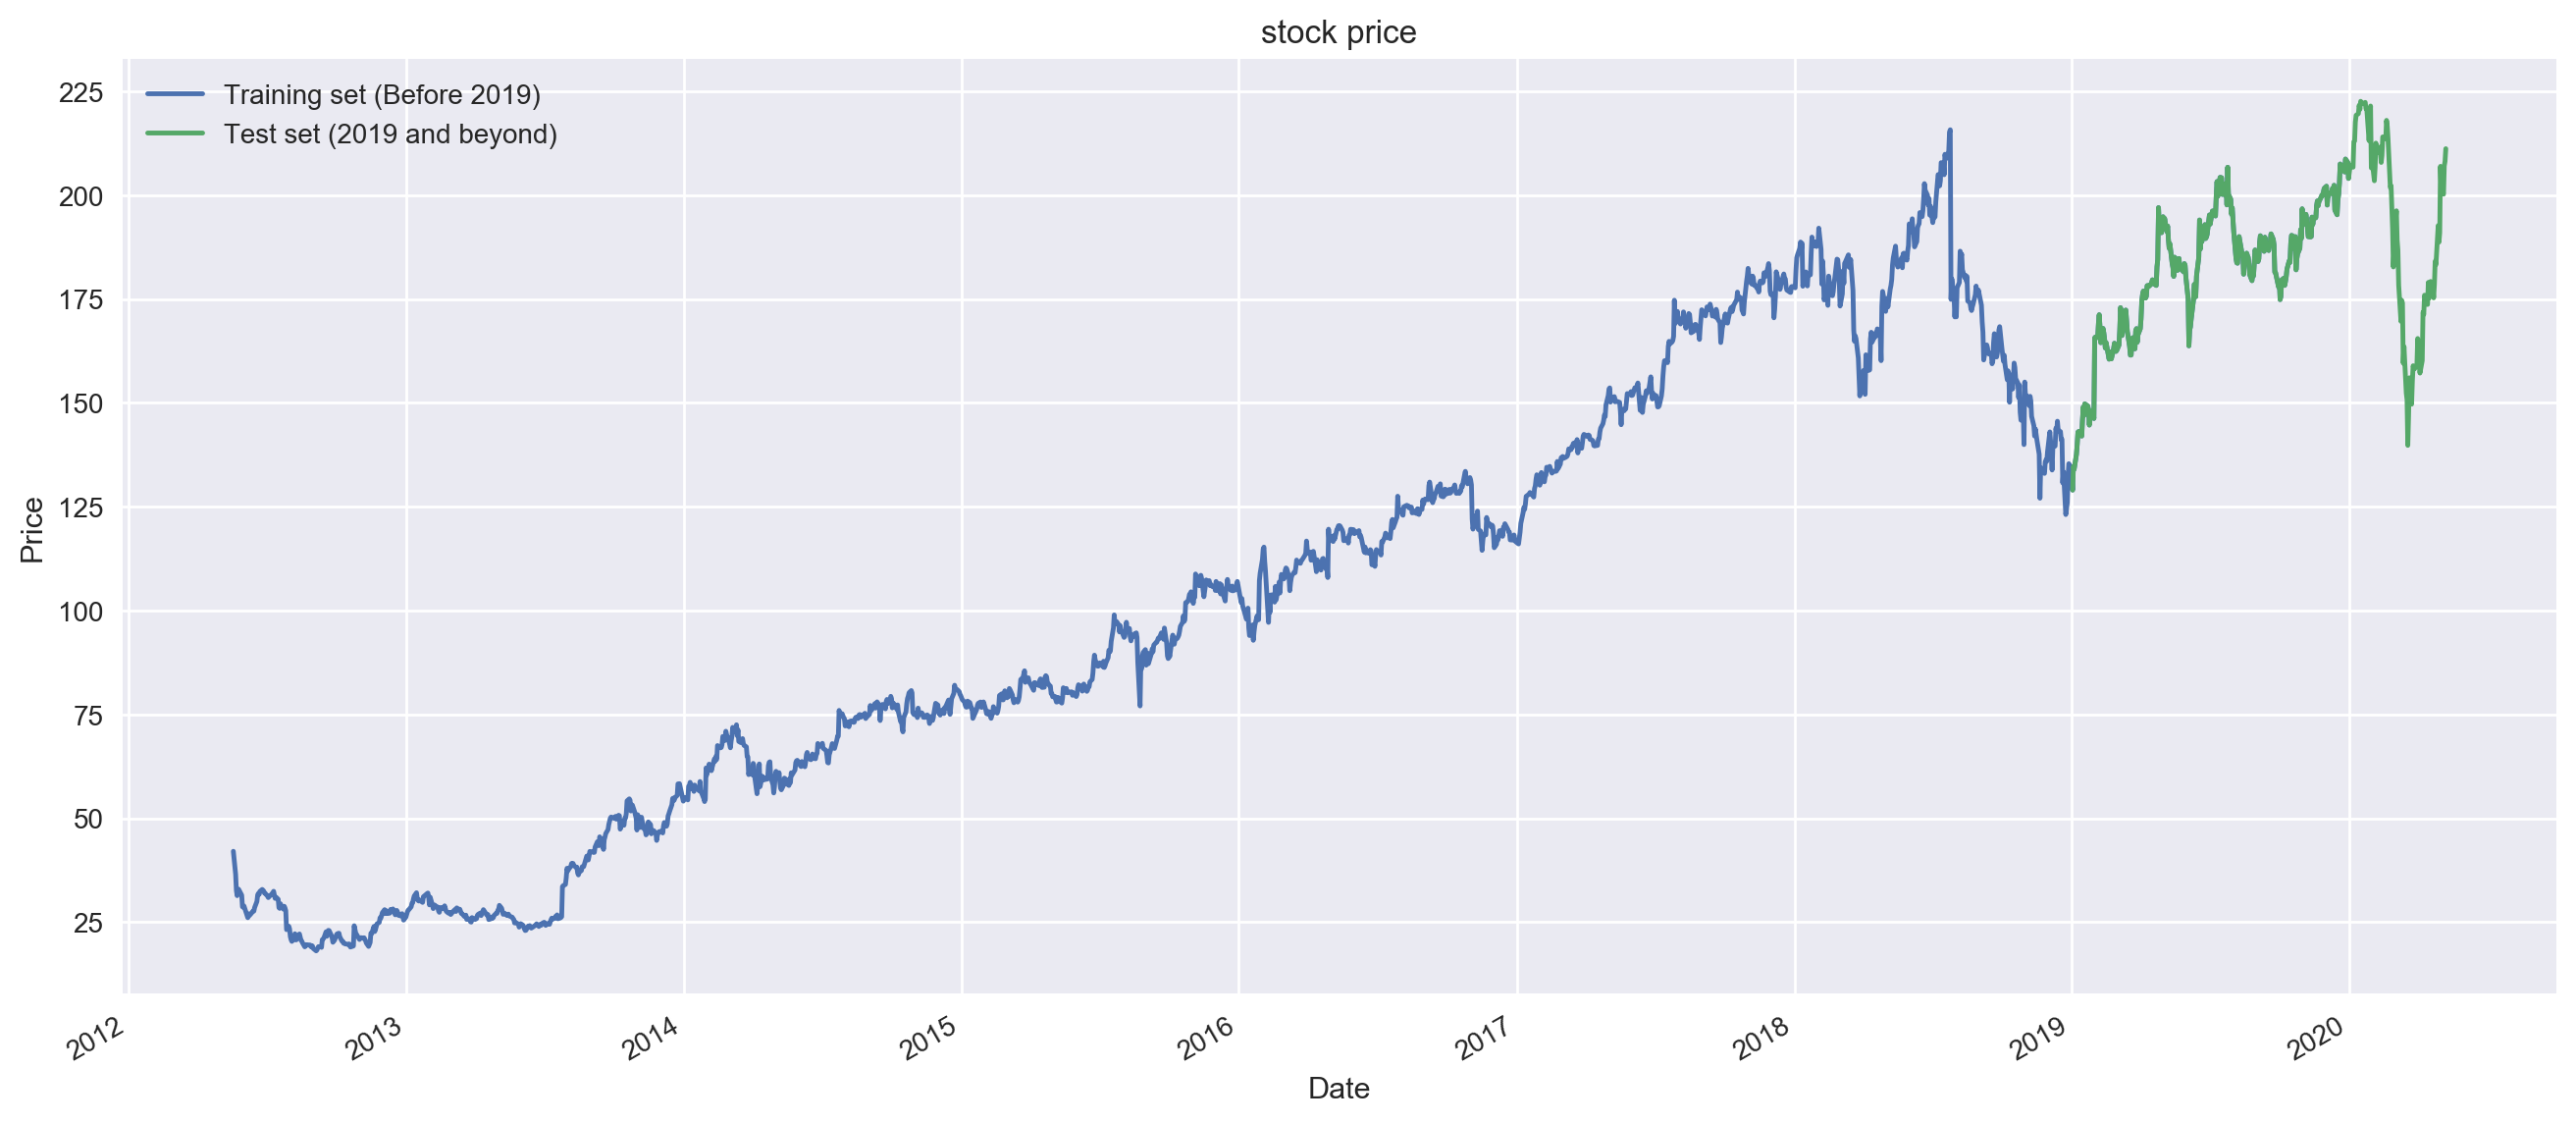

In [6]:
plt.figure(dpi=200,figsize=(16,7))
dataset["Open"][:'2019'].plot(legend=True)
dataset["Open"]['2019':].plot(legend=True)
plt.legend(['Training set (Before 2019)','Test set (2019 and beyond)'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [7]:
train = dataset[:"2018"]["Open"].values


scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))

trn_x,trn_y = make_dataset(train,60)

## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [8]:
trn_x = trn_x.reshape(-1,60,1)


#covert numpy to torch tensors!
trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.FloatTensor)

In [9]:
#load our data into a dataloader object so that we can train our model in batches.

from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
trn = DataLoader(trn,batch_size=1000)

### Model Architecture

* LSTM(50) x 3 layers with 0.2 Dropout.
* Dense(50,1)

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.rnn = nn.LSTM(input_size=1,hidden_size=50,num_layers=3,batch_first=True,dropout=0.2)
        self.out = nn.Linear(50, 1)

    def forward(self, x):

        r_out, (h_n, h_c) = self.rnn(x, None)
        x = r_out[:,-1,:]                    #last hidden output!
        x = self.out(x)
        return x
    
model = Model()

if cuda:
    model.cuda()
    
print(model)

Model(
  (rnn): LSTM(1, 50, num_layers=3, batch_first=True, dropout=0.2)
  (out): Linear(in_features=50, out_features=1, bias=True)
)


In [11]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [12]:
EPOCHS = 5000

trn_loss = []


model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()
      
        y_pred = model(data)
        
        loss = loss_fn(y_pred, target)
        loss.backward()
        
        optimizer.step()
        
    #record loss for every epoch!
    trn_loss.append(loss.cpu().data.item())
    if epoch % 100 == 1:
        print("epoch:", epoch+1,"loss:",trn_loss[-1])
    if epoch > EPOCHS:
        print("Training Complete!")
        break

epoch: 2 loss: 0.6201067566871643
epoch: 102 loss: 0.0020874228794127703
epoch: 202 loss: 0.0017848934512585402
epoch: 302 loss: 0.0026512027252465487
epoch: 402 loss: 0.0013756942935287952
epoch: 502 loss: 0.0012897797860205173
epoch: 602 loss: 0.0012129036476835608
epoch: 702 loss: 0.0011909733293578029
epoch: 802 loss: 0.0010796973947435617
epoch: 902 loss: 0.0010144656989723444
epoch: 1002 loss: 0.0010215687798336148
epoch: 1102 loss: 0.0010066557442769408
epoch: 1202 loss: 0.0008360665524378419
epoch: 1302 loss: 0.000803343253210187
epoch: 1402 loss: 0.00069948669988662
epoch: 1502 loss: 0.0008806679979898036
epoch: 1602 loss: 0.0006859599961899221
epoch: 1702 loss: 0.0006748234154656529
epoch: 1802 loss: 0.0005696190055459738
epoch: 1902 loss: 0.0013826225185766816
epoch: 2002 loss: 0.0005380614893510938
epoch: 2102 loss: 0.0008312493446283042
epoch: 2202 loss: 0.0005368692800402641
epoch: 2302 loss: 0.0004624294815585017
epoch: 2402 loss: 0.0005474017816595733
epoch: 2502 loss: 

---

## Validation

* Test our model on whole data including test set(2019 and beyond)

In [13]:
total = dataset['Open'].values
total_scaled = scaler.transform(total.reshape(-1,1))

total_x,total_y = make_dataset(total_scaled,60)

total_x = torch.from_numpy(total_x).type(torch.FloatTensor)

In [14]:
def predict_with_pytorch(model,val_x):
    model.eval()
    y_preds = []
    
    if cuda:
        val_x = val_x.cuda()
   
    out = model(val_x)
    
    for p in out:
        y_preds.append(p.detach().cpu().numpy().item())
        
        
    return np.array(y_preds).reshape(-1,1)

In [15]:
predicted = predict_with_pytorch(model,total_x)

In [16]:
predicted = scaler.inverse_transform(predicted)

In [17]:
#make a dataset with real and predicted values.

infered = pd.DataFrame(dataset['Open'].iloc[60:])
infered['Open_Predicted'] = predicted

In [18]:
infered.tail()

,Open,Open_Predicted
Date,,
2020-05-01,201.600006,200.344580
2020-05-04,200.199997,197.556592
2020-05-05,207.020004,197.551267
2020-05-06,208.119995,202.158646
2020-05-07,211.160004,203.234349


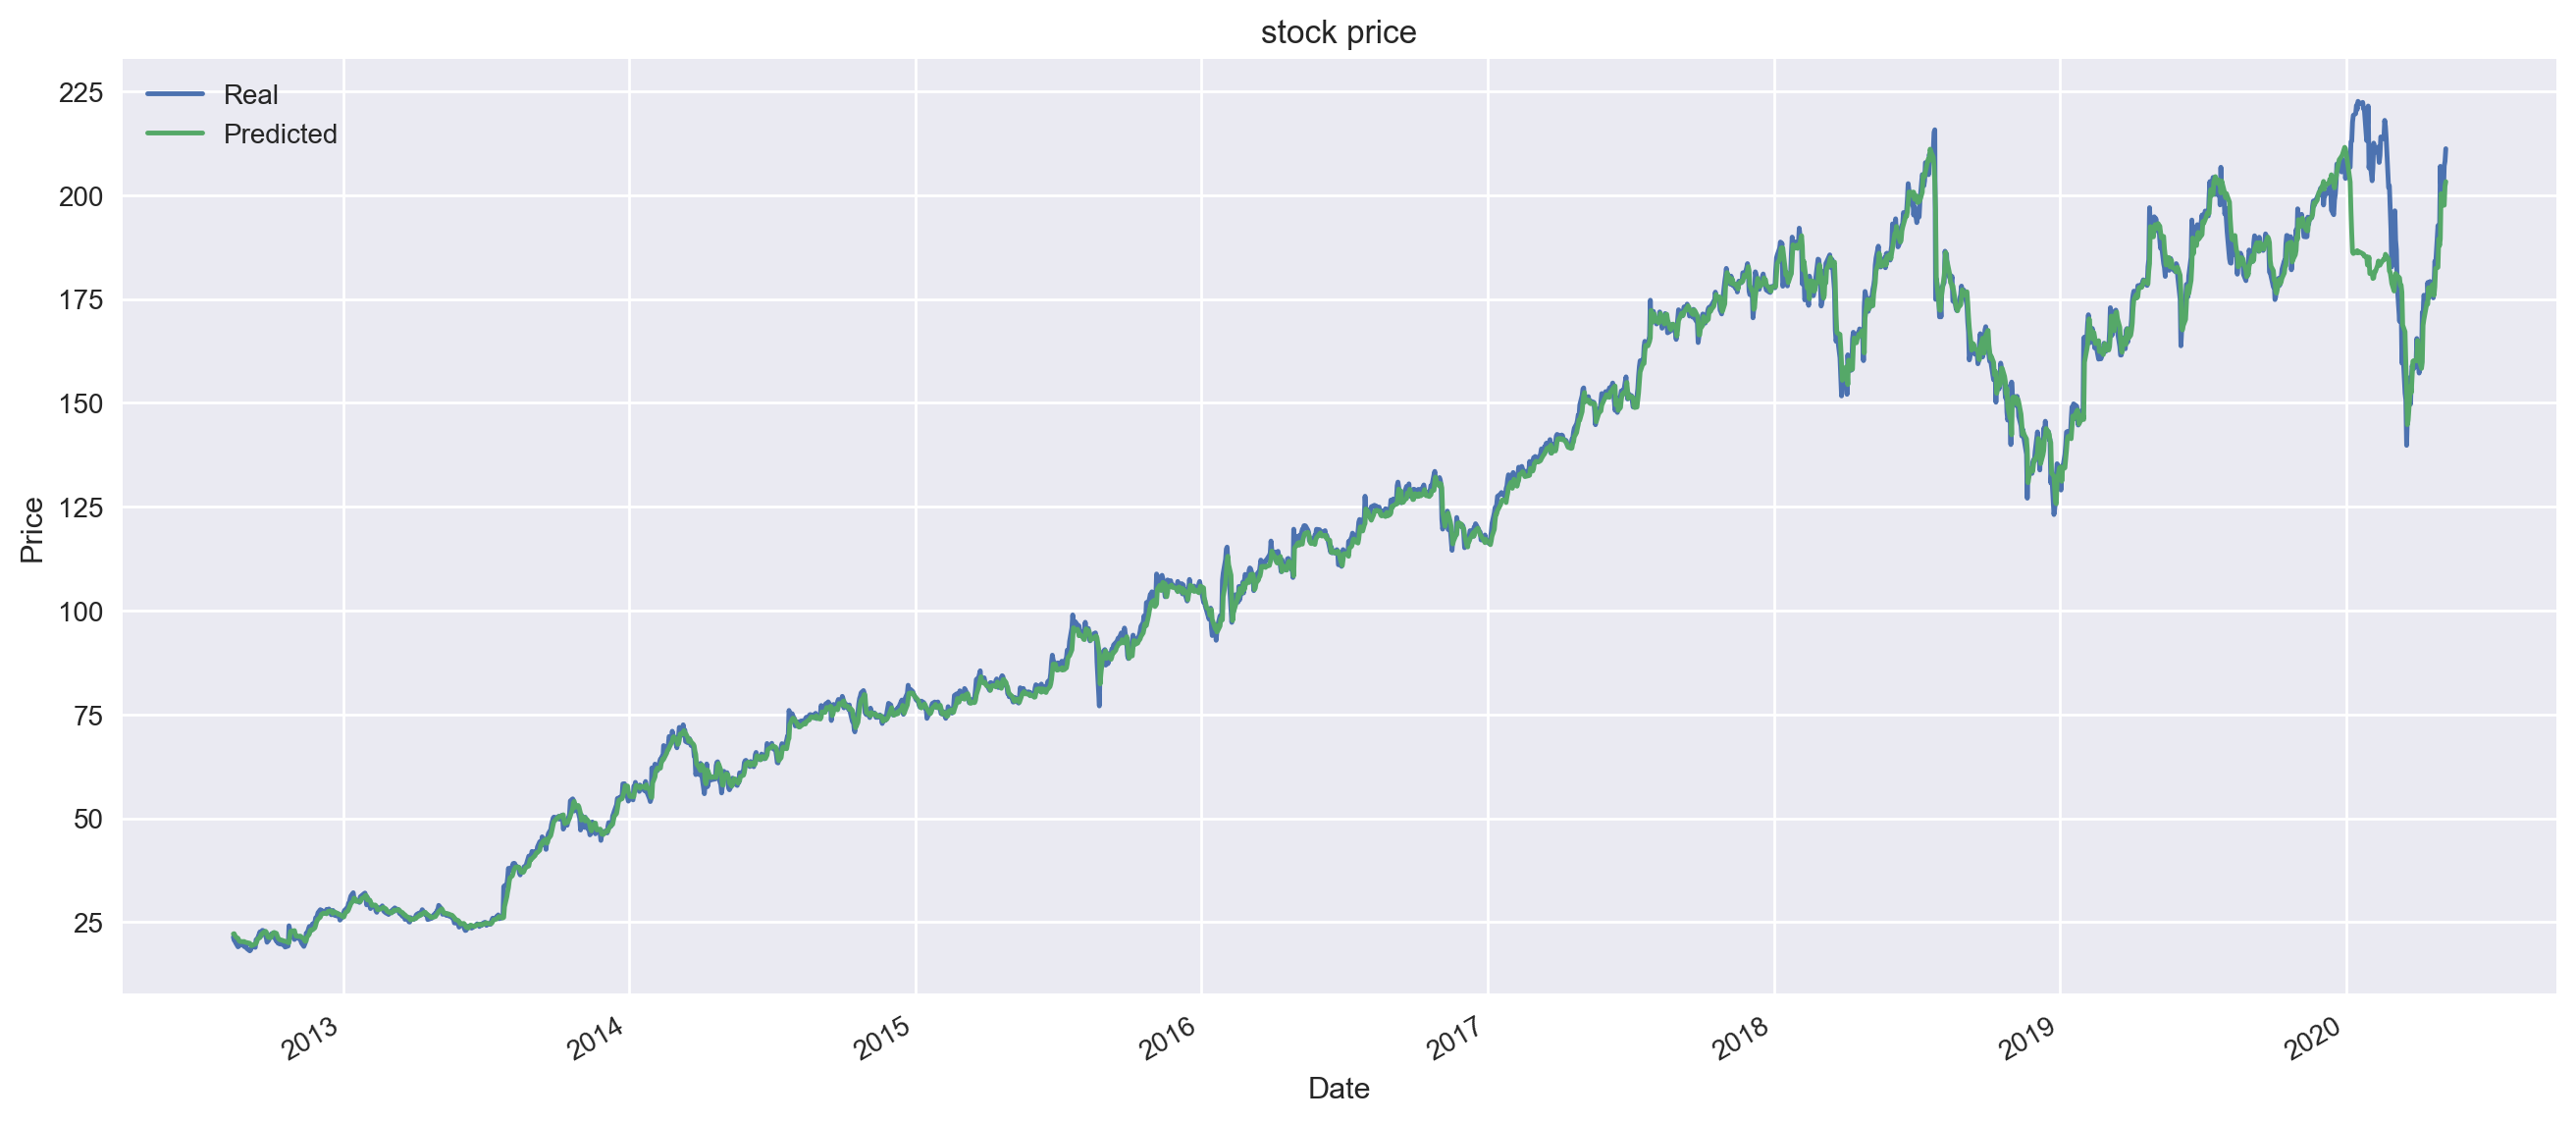

In [19]:
plt.figure(dpi=200,figsize=(16,7))
infered["Open"].plot(legend=True)
infered["Open_Predicted"].plot(legend=True)
plt.legend(['Real','Predicted'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(dataset['Open'].iloc[60:].values,predicted)
print("RMSE:", np.sqrt(mse))

RMSE: 4.835225937405598


---

## Predicting next N days.

**WARNING**: The last prediction (-1) is based on last *N* predicted data aka. **NOT REAL DATA**. This *might* be useful for trend analysis.

In [21]:
#get last predicted value from dataset.

predicted = predict_with_pytorch(model,total_x)
last = scaler.inverse_transform(predicted)[-1]
last = list(last)[-1]

last_p = [last]

print(last_p)

[203.23434863551478]


In [22]:
#Edit Me!
n = 13


for day in range(n):
    print("Remove index 0:", total_scaled[0], "| Add last predicted:", last_p[-1])
    
    #convert to list
    total = list(dataset['Open'].values)
    
    #remove/exclude 1st (0th index)
    total = total[1:]
    
    #add predictions as data to dataset
    for p in last_p:
        print("Added > ",p)
        total.append(p)
    
    #convert to numpy array
    total = np.array(total)
    
    #Scale data!
    total_scaled = scaler.transform(total.reshape(-1,1))
    
    total_x,total_y = make_dataset(total_scaled,60)
    total_x = torch.from_numpy(total_x).type(torch.FloatTensor)

    
    predicted = predict_with_pytorch(model,total_x)
    predicted = scaler.inverse_transform(predicted)
    last = list(predicted[-1])[0]
    print("Model Prediction: ", last)

    last_p.append(last)

Remove index 0: [0.12128111] | Add last predicted: 203.23434863551478
Added >  203.23434863551478
Model Prediction:  205.1128527830123
Remove index 0: [0.09335154] | Add last predicted: 205.1128527830123
Added >  203.23434863551478
Added >  205.1128527830123
Model Prediction:  201.47718118716327
Remove index 0: [0.09335154] | Add last predicted: 201.47718118716327
Added >  203.23434863551478
Added >  205.1128527830123
Added >  201.47718118716327
Model Prediction:  200.67956320407788
Remove index 0: [0.09335154] | Add last predicted: 200.67956320407788
Added >  203.23434863551478
Added >  205.1128527830123
Added >  201.47718118716327
Added >  200.67956320407788
Model Prediction:  196.92141222366368
Remove index 0: [0.09335154] | Add last predicted: 196.92141222366368
Added >  203.23434863551478
Added >  205.1128527830123
Added >  201.47718118716327
Added >  200.67956320407788
Added >  196.92141222366368
Model Prediction:  193.00551175409757
Remove index 0: [0.09335154] | Add last predic

---
## Compare Results

In [23]:
dataset_last_14days["Predicted"] = last_p
dataset_last_14days[["Open", "Predicted"]]

,Open,Predicted
Date,,
2020-05-08,212.240005,203.234349
2020-05-11,210.889999,205.112853
2020-05-12,213.289993,201.477181
2020-05-13,209.429993,200.679563
2020-05-14,202.559998,196.921412
2020-05-15,205.270004,193.005512
2020-05-18,212.149994,188.524265
2020-05-19,213.270004,184.984013
2020-05-20,223.500000,183.058753
